### (now) drop_duplicated_outliers_2
### income state = over median outlier도 제거?
#### 18087보다 더 작아질 것 -> 18082

### (try) duplicated 데이터 income max/avg만 남기기
#### max : duplicated_2 466.40(466.31)
#### avg : duplicated_3 464.50(464.42)

In [1]:
name = 'drop_duplicated_3_outliers_2'

In [2]:
import pandas as pd
import numpy as np
import random
import os

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [4]:
import sklearn
print(sklearn.__version__)

0.24.1


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [7]:
# 'Industry_Status',
# 'Hispanic_Origin',
# 'Household_Status',
# 'Birth_Country',
# 'Birth_Country (Father)', 
# 'Birth_Country (Mother)'

In [8]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [9]:
train.columns

Index(['ID', 'Age', 'Gender', 'Education_Status', 'Employment_Status',
       'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status', 'Race',
       'Hispanic_Origin', 'Martial_Status', 'Household_Status',
       'Household_Summary', 'Citizenship', 'Birth_Country',
       'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status',
       'Gains', 'Losses', 'Dividends', 'Income_Status', 'Income'],
      dtype='object')

In [10]:
features = ['Age', 'Gender', 'Education_Status', 'Employment_Status',
       'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status', 'Race',
       'Hispanic_Origin', 'Martial_Status', 'Household_Status',
       'Household_Summary', 'Citizenship', 'Birth_Country',
       'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status',
       'Gains', 'Losses', 'Dividends', 'Income_Status']

In [11]:
drop_dup_1 = train.drop_duplicates(features)
len(drop_dup_1)

18320

### 학습데이터 중복 행 처리

In [12]:
def concatenate_columns(row):
    columns = [
        row['Age'], row['Gender'], row['Education_Status'], row['Employment_Status'],
        row['Working_Week (Yearly)'], row['Industry_Status'], row['Occupation_Status'],
        row['Race'], row['Hispanic_Origin'], row['Martial_Status'], row['Household_Status'],
        row['Household_Summary'], row['Citizenship'], row['Birth_Country'],
        row['Birth_Country (Father)'], row['Birth_Country (Mother)'], row['Tax_Status'],
        row['Gains'], row['Losses'], row['Dividends'], row['Income_Status']
    ]
    return ''.join(map(str, columns))

train['key'] = train.apply(concatenate_columns, axis=1)

In [13]:
count = 0
total_count = 0
total_count_row = 0
dup_idxs = []
for k in set(train['key']):
    income = train.loc[train['key']==k, 'Income']
    l = list(income)
    if len(l) > 1:
        if len(np.unique(l))>=2: # 중복 존재 & income이 다른 경우
            # train.loc[train['key']==k, 'Income'] = max(l) # max
            train.loc[train['key']==k, 'Income'] = sum(l)/len(l) # avg

In [14]:
drop_dup_2 = train.drop_duplicates(features)
len(drop_dup_2)

18320

### drop duplicated

In [15]:
train.drop_duplicates(features, inplace=True)
train.reset_index(drop=True, inplace=True)

In [16]:
len(train)

18320

##### max로 채우기 mean(600) / std(713)

In [17]:
train.describe()

,Age,Working_Week (Yearly),Gains,Losses,Dividends,Income
count,18320.000000,18320.000000,18320.000000,18320.000000,18320.000000,18320.000000
mean,37.807151,37.608679,418.263646,43.888810,134.772325,597.505149
std,16.759385,20.773594,4328.412823,291.426069,1260.474000,708.007071
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,22.000000,0.000000,0.000000,0.000000,0.000000
50%,36.000000,52.000000,0.000000,0.000000,0.000000,500.000000
75%,48.000000,52.000000,0.000000,0.000000,0.000000,900.000000
max,90.000000,52.000000,99999.000000,4356.000000,45000.000000,9999.000000


#### 중복행 1680

### modify age

In [18]:
# def modify_age(age):
#     if age < 15:
#         return 0
#     elif age < 25:
#         return 1
#     elif age < 40:
#         return 2
#     elif age < 50:
#         return 3
#     elif age < 65:
#         return 4
#     elif age < 80:
#         return 5
#     else:
#         return 6

In [19]:
# train['Age'] = train['Age'].apply(modify_age)
# test['Age'] = test['Age'].apply(modify_age)

In [20]:
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# sns.histplot(x='Age', data=train)

# plt.subplot(1, 2, 2)
# sns.barplot(x='Age', y='Income', data=train)
# plt.show()

### modify education

In [21]:
def modify_education(education):
    if education in ['Children', 'Kindergarten', 'Elementary (1-4)', 'Elementary (5-6)', 
                     'Middle (7-8)', 'High Freshman', 'High Sophomore', 
                     'High Junior', 'High Senior']:
        return 'dropout'
    elif education in ['College', 'Associates degree (Academic)', 'Associates degree (Vocational)']:
        return 'CommunityCollege'
    elif education in ['Professional degree', 'Masters degree']:
        return 'Masters degree'
    else:
        return education

In [22]:
train['Education'] = train['Education_Status']
train['Education'] = train['Education'].apply(modify_education)

In [23]:
test['Education'] = test['Education_Status']
test['Education'] = test['Education'].apply(modify_education)

### household/tax

### modify household

In [24]:
np.unique(train['Household_Summary'])

array(['Child 18 or older', 'Child under 18 ever married',
       'Child under 18 never married',
       'Group Quarters- Secondary individual', 'Householder',
       'Nonrelative of householder', 'Other relative of householder',
       'Spouse of householder'], dtype=object)

In [25]:
def modify_household(household):
    if household == 'Householder':
        return 'Householder'
    elif household in ['Child 18 or older', 'Child under 18 ever married', 'Child under 18 never married', 
                     'Other relative of householder', 'Spouse of householder']:
        return 'dependents'
    else:
        return 'others'

In [26]:
train['Household_Summary'] = train['Household_Summary'].apply(modify_household)
test['Household_Summary'] = test['Household_Summary'].apply(modify_household)

### modify tax status

In [27]:
def modify_tax(tax):
    if tax.startswith('Married'):
        return 'MFJ'
    else:
        return tax

In [28]:
train['Tax_Status'] = train['Tax_Status'].apply(modify_tax)
test['Tax_Status'] = test['Tax_Status'].apply(modify_tax)

<AxesSubplot:xlabel='Count', ylabel='Tax_Status'>

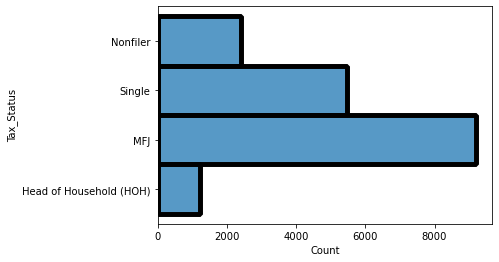

In [29]:
sns.histplot(y='Tax_Status', data=train)

### modify income status

In [30]:
def modify_income_status(status):
    if status in ['Unknown', 'Under Median']:
        return 'Under Median'
    else:
        return status

In [31]:
train['Income_Status'] = train['Income_Status'].apply(modify_income_status)
test['Income_Status'] = test['Income_Status'].apply(modify_income_status)

In [32]:
train

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,...,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income,key,Education
0,TRAIN_00000,63,M,Middle (7-8),Full-Time,4,Social Services,Services,White,All other,...,US,US,Nonfiler,0,0,0,Under Median,425.0,63MMiddle (7-8)Full-Time4Social ServicesServic...,dropout
1,TRAIN_00001,37,M,Associates degree (Vocational),Full-Time,52,Entertainment,Services,White,All other,...,US,US,Single,0,0,0,Under Median,0.0,37MAssociates degree (Vocational)Full-Time52En...,CommunityCollege
2,TRAIN_00002,58,F,High graduate,Full-Time,52,Manufacturing (Non-durable),Admin Support (include Clerical),Black,All other,...,US,US,MFJ,3411,0,0,Under Median,860.0,58FHigh graduateFull-Time52Manufacturing (Non-...,High graduate
3,TRAIN_00003,44,M,High graduate,Full-Time,52,Retail,Technicians & Support,White,All other,...,US,US,Single,0,0,0,Under Median,850.0,44MHigh graduateFull-Time52RetailTechnicians &...,High graduate
4,TRAIN_00004,37,F,High graduate,Full-Time,52,Retail,Sales,White,All other,...,US,US,Head of Household (HOH),0,0,0,Under Median,570.0,37FHigh graduateFull-Time52RetailSalesWhite Al...,High graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18315,TRAIN_19995,33,M,High graduate,Children or Armed Forces,52,Manufacturing (Durable),Handlers/Cleaners,White,All other,...,US,US,Single,0,0,0,Under Median,1300.0,33MHigh graduateChildren or Armed Forces52Manu...,High graduate
18316,TRAIN_19996,20,F,College,Full-Time,12,Education,Admin Support (include Clerical),White,Mexican-American,...,Mexico,Mexico,Nonfiler,0,0,0,Under Median,850.0,20FCollegeFull-Time12EducationAdmin Support (i...,CommunityCollege
18317,TRAIN_19997,22,M,College,Children or Armed Forces,52,Transportation,Technicians & Support,White,All other,...,US,US,Single,0,0,0,Under Median,999.0,22MCollegeChildren or Armed Forces52Transporta...,CommunityCollege
18318,TRAIN_19998,76,F,High graduate,Not Working,0,Not in universe or children,Unknown,White,All other,...,Scotland,England,Single,0,0,0,Under Median,0.0,76FHigh graduateNot Working0Not in universe or...,High graduate


#### 노이즈 제거 (고려)

In [33]:
under = train.loc[train['Income_Status']=='Under Median']

Q1 = np.quantile(under['Income'], 0.25)
Q3 = np.quantile(under['Income'], 0.75)
IOR = Q3-Q1
outlier_step = IOR*1.5

u_outliers = under.loc[(under['Income']<Q1-outlier_step)|(under['Income']>Q3+outlier_step)]
len(u_outliers)

232

(array([153.,  19.,  14.,   8.,   9.,   8.,   4.,   7.,   4.,   6.]),
 array([2251. , 3017.5, 3784. , 4550.5, 5317. , 6083.5, 6850. , 7616.5,
        8383. , 9149.5, 9916. ]),
 <BarContainer object of 10 artists>)

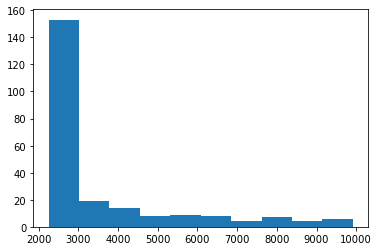

In [34]:
plt.hist(u_outliers['Income'])

In [35]:
over = train.loc[train['Income_Status']=='Over Median']

Q1 = np.quantile(over['Income'], 0.25)
Q3 = np.quantile(over['Income'], 0.75)
IOR = Q3-Q1
outlier_step = IOR*1.5

o_outliers = over.loc[(over['Income']<Q1-outlier_step)|(over['Income']>Q3+outlier_step)]
len(o_outliers)

7

(array([2., 0., 0., 3., 1., 0., 0., 0., 0., 1.]),
 array([4807. , 5326.2, 5845.4, 6364.6, 6883.8, 7403. , 7922.2, 8441.4,
        8960.6, 9479.8, 9999. ]),
 <BarContainer object of 10 artists>)

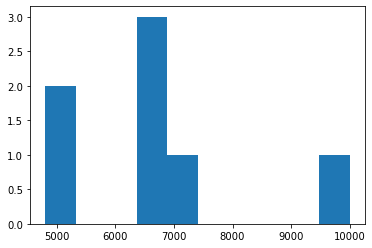

In [36]:
plt.hist(o_outliers['Income'])

In [37]:
outliers = list(u_outliers.index) + list(o_outliers.index)

In [38]:
# train.drop(index=u_outliers.index, inplace=True)
train.drop(index=outliers, inplace=True)
train.reset_index(drop=True, inplace=True)

#### outlier 231 (income state = under median)

### working week

In [39]:
# plt.hist(train['Working_Week (Yearly)'])
# plt.show()

In [40]:
sum(train['Working_Week (Yearly)']<52), sum(train['Working_Week (Yearly)']==52)

(7818, 10263)

##### (7891, 10429)

In [41]:
train['Working_Week (Yearly)'] = np.where(train['Working_Week (Yearly)']<52, 0, 1)
test['Working_Week (Yearly)'] = np.where(test['Working_Week (Yearly)']<52, 0, 1)

In [42]:
# plt.hist(train['Working_Week (Yearly)'])
# plt.show()

### gain, loss, dividend

In [43]:
# train['Gains'] = np.where(train['Gains']>0, 1, 0)
# test['Gains'] = np.where(test['Gains']>0, 1, 0)

# train['Losses'] = np.where(train['Losses']>0, 1, 0)
# test['Losses'] = np.where(test['Losses']>0, 1, 0)

# train['Dividends'] = np.where(train['Dividends']>0, 1, 0)
# test['Dividends'] = np.where(test['Dividends']>0, 1, 0)

In [44]:
train['Capital'] = train['Gains'] + train['Dividends'] - train['Losses']
test['Capital'] = test['Gains'] + test['Dividends'] - test['Losses']

train['Capital'] = np.where(train['Capital']>0, 1, 0)
test['Capital'] = np.where(test['Capital']>0, 1, 0)

### main

In [45]:
trainval_x = train.drop(columns=['ID', 'Income', 
                                #  'Industry_Status',
                                 'Hispanic_Origin', 
                                 'Household_Status', 
                                 'Birth_Country', 
                                 'Birth_Country (Father)', 'Birth_Country (Mother)',
                                 'Education_Status',
                                 'Gains', 'Losses', 'Dividends',
                                 'key'
                                 ])

trainval_y = train['Income']
income_over = train['Income'] > 900
# trainval_y = np.log(train['Income']+1)

test_x = test.drop(columns=['ID',
                            # 'Industry_Status',
                            'Hispanic_Origin', 
                            'Household_Status', 
                            'Birth_Country', 
                            'Birth_Country (Father)', 'Birth_Country (Mother)',
                            'Education_Status',
                            'Gains', 'Losses', 'Dividends'
                            ])

In [46]:
print(np.unique(income_over, return_counts=True))

(array([False,  True]), array([13799,  4282], dtype=int64))


In [47]:
trainval_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18081 entries, 0 to 18080
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    18081 non-null  int64 
 1   Gender                 18081 non-null  object
 2   Employment_Status      18081 non-null  object
 3   Working_Week (Yearly)  18081 non-null  int32 
 4   Industry_Status        18081 non-null  object
 5   Occupation_Status      18081 non-null  object
 6   Race                   18081 non-null  object
 7   Martial_Status         18081 non-null  object
 8   Household_Summary      18081 non-null  object
 9   Citizenship            18081 non-null  object
 10  Tax_Status             18081 non-null  object
 11  Income_Status          18081 non-null  object
 12  Education              18081 non-null  object
 13  Capital                18081 non-null  int32 
dtypes: int32(2), int64(1), object(11)
memory usage: 1.8+ MB


In [48]:
print(len(trainval_x))

18081


In [49]:
encoding_target = list(trainval_x.dtypes[trainval_x.dtypes == "object"].index)

# save_encoder = None
for i in encoding_target:
    le = LabelEncoder()

    # train과 test 데이터셋에서 해당 열의 모든 값을 문자열로 변환
    trainval_x[i] = trainval_x[i].astype(str)
    test_x[i] = test_x[i].astype(str)

    le.fit(trainval_x[i])
    trainval_x[i] = le.transform(trainval_x[i])
    
    # test 데이터의 새로운 카테고리에 대해 le.classes_ 배열에 추가
    for case in np.unique(test_x[i]):
        if case not in le.classes_: 
            print('case')
            le.classes_ = np.append(le.classes_, case)
    
    test_x[i] = le.transform(test_x[i])

    # if i == 'Occupation_Status':
    #     save_encoder = le
    #     print(f'{i}_save')

    if len(np.unique(trainval_x[i])) == 2:
        print(i)
        continue

    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore') ## ignore로 학습 데이터셋에 없는 데이터가 들어와도 무시
    train_encoded = ohe.fit_transform(trainval_x[[i]])

    train_encoded_df = pd.DataFrame(train_encoded, columns=[f"{i}_{j}" for j in range(train_encoded.shape[1])])
    trainval_x = pd.concat([trainval_x.drop(columns=[i]), train_encoded_df], axis=1)
    
    test_encoded = ohe.transform(test_x[[i]])
    
    test_encoded_df = pd.DataFrame(test_encoded, columns=[f"{i}_{j}" for j in range(test_encoded.shape[1])])
    test_x = pd.concat([test_x.drop(columns=[i]), test_encoded_df], axis=1)

Gender
Income_Status


In [50]:
trainval_x.head()

,Age,Gender,Working_Week (Yearly),Income_Status,Capital,Employment_Status_0,Employment_Status_1,Employment_Status_2,Employment_Status_3,Employment_Status_4,...,Tax_Status_0,Tax_Status_1,Tax_Status_2,Tax_Status_3,Education_0,Education_1,Education_2,Education_3,Education_4,Education_5
0,63,1,0,1,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,37,1,1,1,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,58,0,1,1,1,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,44,1,1,1,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,37,0,1,1,0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [51]:
len(train), len(trainval_x), len(income_over)

(18081, 18081, 18081)

In [52]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

In [53]:
num_fold = 1
total_train_error, total_val_error = 0, 0
total_train_error_post, total_val_error_post = 0, 0
test_preds = []
for train_idx, val_idx in kf.split(trainval_x, income_over):
    train_x = trainval_x.iloc[train_idx]
    train_y = trainval_y.iloc[train_idx]

    val_x = trainval_x.iloc[val_idx]
    val_y = trainval_y.iloc[val_idx]

    model = GradientBoostingRegressor(max_depth=4)
    # model.fit(train_x, train_y)
    model.fit(train_x, train_y)

    print(f'{num_fold} fold')

    train_y_hat = model.predict(train_x)
    val_y_hat = model.predict(val_x)

    pred = model.predict(test_x)

    test_preds.append(pred)

    train_error = mean_squared_error(train_y, train_y_hat) ** 0.5
    val_error = mean_squared_error(val_y, val_y_hat) ** 0.5

    total_train_error += train_error
    total_val_error += val_error

    train_y_hat_post = np.where(train_y_hat<0, 0, train_y_hat)
    val_y_hat_post = np.where(val_y_hat<0, 0, val_y_hat)

    train_error_post = mean_squared_error(train_y, train_y_hat_post) ** 0.5
    val_error_post = mean_squared_error(val_y, val_y_hat_post) ** 0.5

    total_train_error_post += train_error_post
    total_val_error_post += val_error_post

    print(f'train error : {train_error:.2f} | val error : {val_error:.2f}')
    print(f'[post] train error : {train_error_post:.2f} | val error : {val_error_post:.2f}')
    
    print('-'*30)

    # feature_importances = model.feature_importances_
    # importance_df = pd.Series(feature_importances[:20], index=trainval_x.columns[:20])
    # importance_df.sort_values(inplace=True)

    # plt.barh(np.arange(len(importance_df)), importance_df)
    # plt.yticks(np.arange(len(importance_df)), importance_df.index)
    # plt.show()

    num_fold += 1

1 fold
train error : 442.67 | val error : 469.87
[post] train error : 442.59 | val error : 469.77
------------------------------
2 fold
train error : 445.93 | val error : 457.58
[post] train error : 445.83 | val error : 457.48
------------------------------
3 fold
train error : 443.17 | val error : 470.03
[post] train error : 443.10 | val error : 469.95
------------------------------
4 fold
train error : 443.23 | val error : 463.60
[post] train error : 443.14 | val error : 463.50
------------------------------
5 fold
train error : 443.91 | val error : 461.43
[post] train error : 443.85 | val error : 461.38
------------------------------


In [54]:
print(f'final train error : {total_train_error/5:.2f}')
print(f'final val error : {total_val_error/5:.2f}')

print(f'[post] final train error : {total_train_error_post/5:.2f}')
print(f'[post] final val error : {total_val_error_post/5:.2f}')

final train error : 443.78
final val error : 464.50
[post] final train error : 443.70
[post] final val error : 464.42


In [55]:
final_pred = np.array(test_preds).mean(0)

In [56]:
final_pred_post = np.where(final_pred<0, 0, final_pred)

In [57]:
# final_pred_exp = np.exp(final_pred)-1

In [58]:
submission = pd.read_csv('data/sample_submission.csv')

In [59]:
submission['Income'] = final_pred
submission['Income'] = final_pred_post
# submission['Income'] = final_pred_exp
submission

,ID,Income
0,TEST_0000,0.000000
1,TEST_0001,29.557687
2,TEST_0002,345.336497
3,TEST_0003,559.482552
4,TEST_0004,0.000000
...,...,...
9995,TEST_9995,802.070387
9996,TEST_9996,679.956806
9997,TEST_9997,352.482032
9998,TEST_9998,0.000000


In [60]:
os.makedirs('submission', exist_ok=True)
submission.to_csv(f'submission/{name}.csv', index=False)

(array([300., 154.,  98.,  37.,  28.,  10.,   5.,   6.,   0.,   1.]),
 array([1000.19839791, 1085.17725191, 1170.15610591, 1255.13495992,
        1340.11381392, 1425.09266792, 1510.07152192, 1595.05037592,
        1680.02922993, 1765.00808393, 1849.98693793]),
 <BarContainer object of 10 artists>)

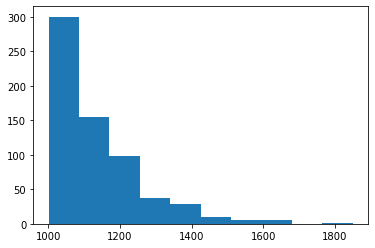

In [61]:
plt.hist(final_pred_post[final_pred_post>1000])

(array([1489.,  934.,  620.,  315.,   62.,   21.,   10.,    9.,    2.,
           4.]),
 array([1001. , 1300.9, 1600.8, 1900.7, 2200.6, 2500.5, 2800.4, 3100.3,
        3400.2, 3700.1, 4000. ]),
 <BarContainer object of 10 artists>)

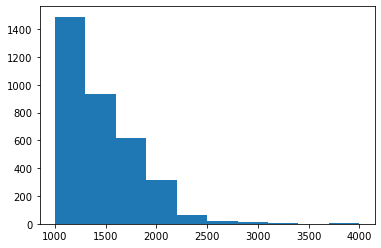

In [62]:
plt.hist(train.loc[train['Income']>1000, 'Income'])